# Preliminary operations

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import copy
import pickle
import os
import plotly.express as px
import matplotlib.pyplot as plt
import tensorflow as tf
import time

# Set seeds
seed = 123
tf.keras.utils.set_random_seed(seed)

# Get environment variables
fail_name = os.environ.get('FAIL', 'underground_greedy')
do_train = os.environ.get('TRAIN', 'no')
do_all = os.environ.get('RUN', 'no')

total_time = 0

In [2]:
%run utils.ipynb

In [3]:
%run preprocessing.ipynb

In [4]:
%run preparation.ipynb

In [5]:
%run training_transformer.ipynb

In [6]:
%run predict.ipynb

In [7]:
# If set to yes, the next cells will retrain the model on training data
# Otherwise, prediction mode will be set
event_name = fail_name
to_train = do_train
run_all = do_all

In [8]:
'''
event_name = 'underground_greedy'
to_train = 'no'
run_all = 'no'
'''

"\nevent_name = 'underground_greedy'\nto_train = 'no'\nrun_all = 'no'\n"

# Training

## Preprocessor

In [9]:
if run_all == "no":
    print('--------------------------------')
    print('| PREPROCESSOR - TRAINING DATA |')
    print('--------------------------------\n')
start = time.perf_counter()

--------------------------------
| PREPROCESSOR - TRAINING DATA |
--------------------------------



In [10]:
# Read old and new training data
data_path = 'datasets/raw/sf_normal_final_indicators_97200.csv'
df = pd.read_csv(data_path)
data_path_continual = 'datasets/raw/continual/sf_normal_final_indicators_18000_day.csv'
df_continual = pd.read_csv(data_path_continual)
number_of_features = len(df_continual.columns)

In [11]:
# Save interactive html visualization for training data
title = f"Simulation indicators time series: interactive line plot <br><sup>City: San Francisco, Scenario: normal (continual), Hour: day</sup>"
save_path = 'html_plots/continual/normal_day.html'
fig = px.line(df_continual[5400:-1800], x = df_continual[5400:-1800].index, y = df_continual[5400:-1800].columns, title = title) # Delete stabilization time
fig.update_layout(legend_title_text = 'Indicators')
fig.write_html(save_path)

In [12]:
# List of parameters for preprocessing
params = [
    ['timestamp', 'rides_requested',  'rides_accepted', 'rides_not_served', 'rides_canceled'],
    False, # ratio
    False, # smoothing
    False, # collinearity
    False, # log
    300, # aggregation
    False, # statistics
    1, # differencing
    True, # seasonality
    True # normalize
]

scaler_path = f"df_{len(params[0])}_{params[1]}_{params[2]}_{params[3]}_{params[4]}_{params[5]}_{params[6]}_{params[7]}_{params[8]}_{params[9]}"

# Apply preprocessing strategy according to previous parameters selection
df_ = copy.deepcopy(df)
df_proc, scaler = preprocessing(df_,
                        columns_to_remove = params[0],
                        ratio = params[1],
                        smoothing = params[2],
                        collinearity = params[3],
                        log = params[4],
                        aggregation = params[5],
                        statistics = params[6],
                        differencing = params[7],
                        seasonality = params[8],
                        normalize = params[9],
                        load_scaler = False,        # Set to True only for test data, it will load the training scaler
                        save = True,                # Save dataset to datasets/proc
                        continual = False)

scaler_path_continual = f"continual_df_{len(params[0])}_{params[1]}_{params[2]}_{params[3]}_{params[4]}_{params[5]}_{params[6]}_{params[7]}_{params[8]}_{params[9]}"
df_continual_ = copy.deepcopy(df_continual)
df_proc_continual, scaler_continual = preprocessing(df_continual_,
                        columns_to_remove = params[0],
                        ratio = params[1],
                        smoothing = params[2],
                        collinearity = params[3],
                        log = params[4],
                        aggregation = params[5],
                        statistics = params[6],
                        differencing = params[7],
                        seasonality = params[8],
                        normalize = params[9],
                        load_scaler = False,        # Set to True only for test data, it will load the training scaler
                        save = True,                # Save dataset to datasets/proc
                        continual = True)

In [13]:
# Prepare old training set
train_set = preparation(df_proc,
                        window_size = 20,  # Windowing for transformer model
                        overlap = 0,       # Number of observations to overlap for each window. MUST be < window size
                        val_hours = 0)     # Hours to consider for validation set
# Prepare new training set for continual learning
train_set_continual = preparation(df_proc_continual,
                        window_size = 20,  # Windowing for transformer model
                        overlap = 0,       # Number of observations to overlap for each window. MUST be < window size
                        val_hours = 0)     # Hours to consider for validation set

In [14]:
finish = time.perf_counter()
if run_all == "no":
    print('PREPROCESSOR execution time: ' + str(round(finish - start, 3)) + ' seconds\n')
total_time += finish - start

PREPROCESSOR execution time: 3.053 seconds



## Denoising Transformer Autoencoder

In [15]:
# Continual learning with new data
if to_train == 'yes':
    start = time.perf_counter()
    if run_all == "no":
        print('----------------------------------------------------------')
        print('| DENOISING TRANSFORMER AUTOENCODER - CONTINUAL LEARNING |')
        print('----------------------------------------------------------\n')
    # Fine-tune with MAS
    updated_model = mas_finetune_on_new_task(
        model_path = "models/transformer_autoencoder_1_8_128_256_02_00001_500_mse_32.pkl",
        old_data = train_set,
        new_data = train_set_continual,
        lambda_ = 1.0,
        n_epochs = 100,
        batch_size = 32,
        learning_rate = 1e-4
    )
else:
    # Just load the model already trained, be sure to enter the right path
    updated_model_path = 'models/transformer_autoencoder_MAS.pkl'
    with open(updated_model_path, 'rb') as file:
        updated_model = pickle.load(file)

In [16]:
if to_train == 'yes':
    finish = time.perf_counter()
    if run_all == 'no':
        print('DENOISING TRANSFORMER AUTOENCODER execution time: ' + str(round(finish - start, 3)) + ' seconds\n')
    total_time += finish - start

## Predictor

In [17]:
if to_train == 'yes':
    start = time.perf_counter()
    if run_all == 'no':
        print('-----------------------------')
        print('| PREDICTOR - TRAINING DATA |')
        print('-----------------------------\n')

In [18]:
if to_train == 'yes':
    # Predict and assess performance on training set
    original, reconstructed = predict(updated_model, train_set_continual, scaler_path_continual, sequential = True)

    # Save metrics plots and dataframes
    num_features = min(train_set_continual.shape[2], len(df_proc_continual.columns))
    mae = save_predict_plots(original, reconstructed, df_proc_continual.columns, num_features, scaler_path_continual, model_type = 'continual/transformer_normal', plot = False, compute_df = True)

    # Plot training set reconstruction performance
    '''
    for column in range(0, len(df_proc.columns)):
        plt.figure(figsize = (10, 6))
        plt.plot(original[:, column], label = 'Original Features')
        plt.plot(reconstructed[:, column], label = 'Reconstructed Features', linestyle='--')
        plt.title(df_proc.columns[column])
        plt.xlabel("Timestamp")
        plt.ylabel("Value")
        plt.legend()
        plt.show()
        plt.close()
    '''

Combined training MAE autoencoder out of range for 75 consecutive timestamps



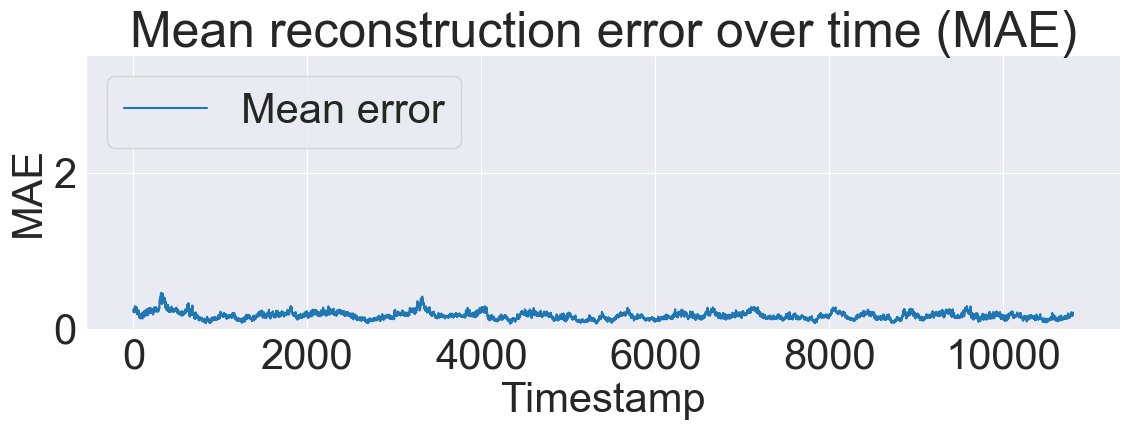

In [19]:
# Load metrics training dataset
mae_df = pd.read_csv("predictions/continual/transformer_normal_mae.csv")
mae_df_old = pd.read_csv("predictions/transformer_normal_mae.csv")

# Compute error on training set
mean_err_mae_norm = (mae_df - mae_df.min()) / (mae_df.max() - mae_df.min())
mean_err_mae_norm = mean_err_mae_norm.mean(axis = 1)
mean_err_mae_norm_old = (mae_df_old - mae_df_old.min()) / (mae_df_old.max() - mae_df_old.min())
mean_err_mae_norm_old = mean_err_mae_norm_old.mean(axis = 1)
mean_err_mae_norm_new = (mae_df - mae_df.min()) / (mae_df.max() - mae_df.min())
mean_err_mae_norm_new = mean_err_mae_norm_new.mean(axis = 1)

# Compute max training consecutive error > 99perc
threshold = np.percentile(pd.concat([mean_err_mae_norm, mean_err_mae_norm_old]), 99)
high_error_timestamps = np.where(mean_err_mae_norm_old > threshold)[0]
max_count = 0
current_count = 0
prev_timestamp = None
for timestamp in high_error_timestamps:
    if prev_timestamp is not None and timestamp == prev_timestamp + 1:
        current_count += 1
    else:
        max_count = max(max_count, current_count)
        current_count = 1
    prev_timestamp = timestamp

if run_all == "no":
    print(f"Combined training MAE autoencoder out of range for {max_count} consecutive timestamps\n")

# Plot and save new training error
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams.update({'font.size': 30})
plt.plot(mean_err_mae_norm, label = 'Mean error')
plt.title('Mean reconstruction error over time (MAE)')
plt.xlabel('Timestamp')
plt.ylabel('MAE')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.ylim([0, 3.5])
plt.tight_layout()
plt.savefig('results/continual_normal_MAE_transformer.png', dpi = 300)
plt.show()
plt.close()

In [20]:
if to_train == 'yes':
    finish = time.perf_counter()
    if run_all == 'no':
        print('PREDICTOR execution time: ' + str(round(finish - start, 3)) + ' seconds\n')
    total_time += finish - start

# Event

## Preprocessor

We compute the timestamp of the (possible) failure.

In [21]:
if run_all == 'no':
    print('-----------------------------')
    print('| PREPROCESSOR - EVENT DATA |')
    print('-----------------------------\n')
start = time.perf_counter()

-----------------------------
| PREPROCESSOR - EVENT DATA |
-----------------------------



In [22]:
# Fail name and hour of the day
event = event_name
hour = 'day'

In [23]:
# Read data
data_path_old = 'datasets/raw/sf_normal_final_indicators_97200.csv'
df_old = pd.read_csv(data_path_old)
data_path = 'datasets/raw/continual/sf_normal_final_indicators_18000_day.csv'
df = pd.read_csv(data_path)
data_path_event = 'datasets/raw/continual/sf_' + event + '_final_indicators_18000_' + hour + '.csv'
df_event = pd.read_csv(data_path_event)
df_complete = pd.concat([df[6900:-1800], df_continual[6900:-1800]])
if 'timestamp' in df_event.columns:
    df_event = df_event.drop('timestamp', axis = 1)

In [24]:
# Save interactive html visualization for training data
title = f"Simulation indicators time series: interactive line plot <br><sup>City: San Francisco, Scenario: normal, Hour: day</sup>"
save_path = 'html_plots/continual/normal_day.html'
fig = px.line(df[5400:-1800], x = df[5400:-1800].index, y = df[5400:-1800].columns, title = title) # Delete stabilization time
fig.update_layout(legend_title_text = 'Indicators')
fig.write_html(save_path)

In [25]:
# Define the values for x1, x2 and their corresponding y values
x1, y1 = 0, 0
x2, y2 = df_complete['rides_requested'][6900:-1800].mean(), 1 # Scaling factor = 1 when rides requested >= mean
# Adjust b to ensure the function is defined at x = 0
b = 0.1
# Values of ln(x+b) at x1 and x2
ln_x1_b = np.log(x1 + b)
ln_x2_b = np.log(x2 + b)
# System of equations:
# a * ln(0.1) + c = 0
# a * ln(df['rides_requested'].mean()) + c = 1
# We can represent this system as matrix equations A * [a, c] = Y
A = np.array([
    [ln_x1_b, 1],
    [ln_x2_b, 1]
])
Y = np.array([y1, y2])
# Solve for coefficients a and c
coefficients = np.linalg.solve(A, Y)
a, c = coefficients

In [26]:
# Aggregate data by 300 timestamps (5 minutes), using average
for column in df.columns:
    df[column] = np.around(df[column].astype(float), 5)
    df[column] = df[column].rolling(window = 300).mean()
df = df[6900:-1800].reset_index(drop = True)
for column in df_event.columns:
    df_event[column] = np.around(df_event[column].astype(float), 5)
    df_event[column] = df_event[column].rolling(window = 300).mean()
df_event = df_event[6900:-1800].reset_index(drop = True)
for column in df_old.columns:
    df_old[column] = np.around(df_old[column].astype(float), 5)
    df_old[column] = df_old[column].rolling(window = 300).mean()
df_old = df_old[6900:-1800].reset_index(drop = True)

In [27]:
# Compute failed requests (hardiness)
failed_requests_train = [0] * len(df)
failed_requests_train_old = [0] * len(df_old)
for i in range(0, len(df)):
    failed_requests_train[i] = compute_failed_requests(df['rides_not_served'][i]+df['rides_canceled'][i], df['rides_requested'][i], a, b, c)
for i in range(0, len(df_old)):
    failed_requests_train_old[i] = compute_failed_requests(df_old['rides_not_served'][i]+df_old['rides_canceled'][i], df_old['rides_requested'][i], a, b, c)
hardiness_train = pd.Series(failed_requests_train)
hardiness_train_old = pd.Series(failed_requests_train_old)
failed_requests_event = [0] * len(df_event)
for i in range(0, len(df_event)):
    failed_requests_event[i] = compute_failed_requests(df_event['rides_not_served'][i]+df_event['rides_canceled'][i], df_event['rides_requested'][i], a, b, c)
hardiness_event = pd.Series(failed_requests_event)[:9000]

# Compute consistency
consistency_train = hardiness_train.rolling(window = 300).std().fillna(0).reset_index(drop = True)
consistency_train_old = hardiness_train_old.rolling(window = 300).std().fillna(0).reset_index(drop = True)
consistency_event = hardiness_event.rolling(window = 300).std().fillna(0).reset_index(drop = True)[:9000]

# Compute resilience threshold
threshold = np.percentile(hardiness_train, 99)
threshold_old = np.percentile(hardiness_train_old, 99)
perc_99_r = compute_time_above(hardiness_train, 1800)
perc_99_r_old = compute_time_above(hardiness_train_old, 1800)
perc_99_r = max(perc_99_r, perc_99_r_old)

In [28]:
# By calling the function compute_thresholds, the code automatically compute the following thresholds
perc_95_h, perc_97_h, perc_99_h = compute_thresholds(pd.concat([hardiness_train, hardiness_train_old]))
perc_95_c, perc_97_c, perc_99_c = compute_thresholds(pd.concat([consistency_train, consistency_train_old]))

# Compute timestamps exceeding the thresholds
exceed_timestamps_h = {
    'perc_95': 0,
    'perc_97': 0,
    'perc_99': 0
}
exceed_timestamps_c = {
    'perc_95': 0,
    'perc_97': 0,
    'perc_99': 0
}
exceed_timestamps_h = exceed_thresholds(hardiness_event, exceed_timestamps_h, perc_95_h, perc_97_h, perc_99_h)
exceed_timestamps_c = exceed_thresholds(consistency_event, exceed_timestamps_c, perc_95_c, perc_97_c, perc_99_c)
exceed_timestamps_r, consecutive_t = compute_resilience(hardiness_event, perc_99_r, 1800)

In [29]:
if exceed_timestamps_h.get('perc_99') != 0:
    print(f"Hardiness out of range at timestamp(s) {exceed_timestamps_h['perc_99']}")
else:
    print(f"Hardiness not out of range")
if exceed_timestamps_c.get('perc_99') != 0:
    print(f"Consistency out of range at timestamp {exceed_timestamps_c['perc_99']}")
else:
    print(f"Consistency not out of range")
if exceed_timestamps_r != 0:
    print(f"Resilience out of range at timestamp {exceed_timestamps_r}, and for {consecutive_t - perc_99_r} consecutive timestamps more than threshold\n")
else:
    print(f"Resilience not out of range\n")

Hardiness out of range at timestamp(s) 4678
Consistency out of range at timestamp 4664
Resilience out of range at timestamp 5924, and for 196 consecutive timestamps more than threshold



In [30]:
failure_timestamp = 0
if exceed_timestamps_r != 0 and exceed_timestamps_c['perc_99'] != 0 and exceed_timestamps_h['perc_99'] !=0:
    failure_timestamp = max(exceed_timestamps_h['perc_99'], exceed_timestamps_c['perc_99'], exceed_timestamps_r)

In [31]:
# Plot hardiness

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 30})

perc_99_h_time = exceed_timestamps_h.get('perc_99', 0)
plt.plot(hardiness_event, label = 'Failed requests')
plt.title('Hardiness for Failed requests index')
plt.xlabel('Timestamp')
plt.ylabel('Percentage (x100%)')
plt.axhline(y = perc_99_h, color = 'red', linestyle = '--', label = 'Hardiness threshold')
plt.axvline(x = 3600, color = 'blue', label = 'Event injection')
plt.annotate(f'99th percentile (H)', xy = (1500, perc_99_h),
             xytext = (2300, perc_99_h + 0.02),
             horizontalalignment = 'center', color = 'red')

if perc_99_h_time != 0:
    plt.axvline(x = perc_99_h_time, color = 'red', linestyle = '-', label = 'Hardiness OOR')

plt.ylim(0, 1)
plt.xlim(-400, 9400)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.tight_layout()
#plt.show()
plt.close()

In [32]:
# Plot consistency

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 30})

perc_99_c_time = exceed_timestamps_c.get('perc_99', 0)
plt.plot(consistency_event, label = 'Failed requests (std dev)')
plt.title('Consistency for Failed requests index')
plt.xlabel('Timestamp')
plt.ylabel('Percentage (x100%)')
plt.axhline(y = perc_99_c, color = 'black', linestyle = '--', label = 'Consistency threshold')
plt.axvline(x = 3600, color = 'blue', label = 'Event injection')
plt.annotate(f'99th percentile (C)', xy = (1500, perc_99_c),
             xytext = (2300, perc_99_c + 0.002),
             horizontalalignment = 'center', color = 'black')

if perc_99_c_time != 0:
    plt.axvline(x = perc_99_c_time, color = 'black', label = 'Consistency OOR')

plt.ylim(0, 0.12)
plt.xlim(-400, 9400)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.tight_layout()
#plt.show()
plt.close()

In [33]:
# Plot resilience

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 30})

perc_99_r_time = exceed_timestamps_r
plt.plot(hardiness_event, label = 'Failed requests')
plt.plot(hardiness_event[(perc_99_r_time-perc_99_r):perc_99_r_time+consecutive_t-perc_99_r], color = 'purple', label = "Resilience degradation")
plt.title('Resilience for Failed requests index')
plt.xlabel('Timestamp')
plt.ylabel('Percentage (x100%)')
plt.axvline(x = 3600, color = 'blue', label = 'Event injection')
plt.annotate('Resilience starts degrading', xy = (perc_99_r_time - perc_99_r, 0.2), xytext = (perc_99_r_time - perc_99_r - 2000, 0.3),
             horizontalalignment = 'center', color = 'purple', arrowprops = dict(arrowstyle = "->", color = 'purple', lw = 1.5))
plt.axvline(x = perc_99_r_time - perc_99_r, color = 'purple', linestyle = '--', label = 'Start of recovery counter')

if perc_99_r_time != 0:
    plt.axvline(x = perc_99_r_time, color = 'purple', label = 'Resilience OOR')

plt.ylim(0, 1)
plt.xlim(-400, 9400)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.tight_layout()
#plt.show()
plt.close()

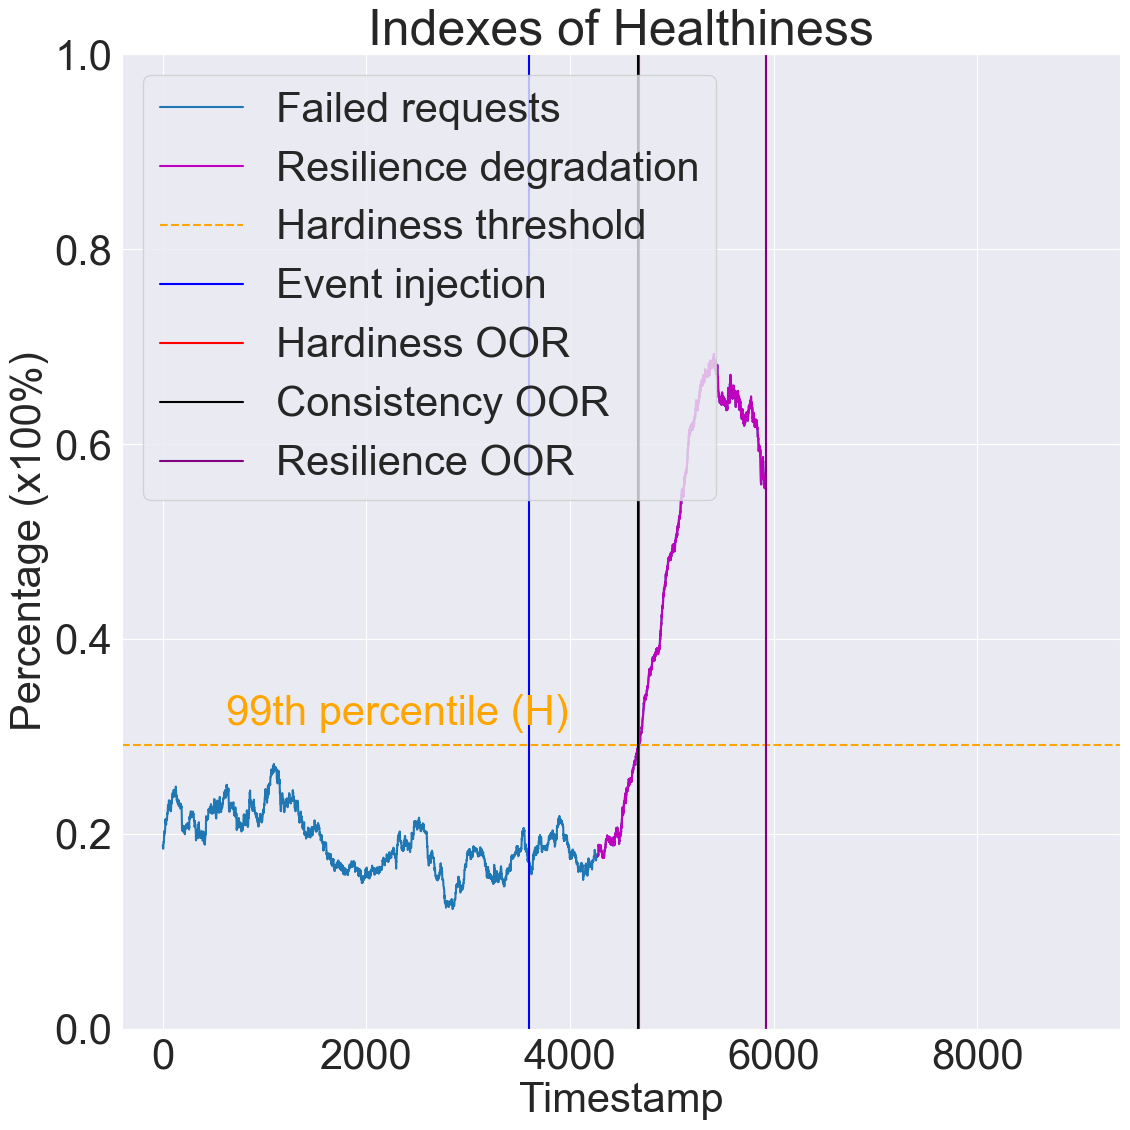

Failed_requests index saved to 'failed_requests/continual/' folder



In [34]:
# Plot hardiness, consistency and resilience

plt.rcParams["figure.figsize"] = (12, 12)
plt.rcParams.update({'font.size': 30})

perc_99_h_time = exceed_timestamps_h.get('perc_99', 0)
perc_99_c_time = exceed_timestamps_c.get('perc_99', 0)
perc_99_r_time = exceed_timestamps_r
if failure_timestamp > 0:
    plt.plot(hardiness_event[:failure_timestamp], label = 'Failed requests')
else:
    plt.plot(hardiness_event, label = 'Failed requests')
if perc_99_r_time != 0:
    plt.plot(hardiness_event[(perc_99_r_time-perc_99_r):min(failure_timestamp, perc_99_r_time+consecutive_t-perc_99_r)], color = 'm', label = "Resilience degradation")
plt.title('Indexes of Healthiness')
plt.xlabel('Timestamp')
plt.ylabel('Percentage (x100%)')
plt.axhline(y = perc_99_h, color = 'orange', linestyle = '--', label = 'Hardiness threshold')
plt.axvline(x = 3600, color = 'blue', label = 'Event injection')
plt.annotate(f'99th percentile (H)', xy = (1500, perc_99_h),
             xytext = (2300, perc_99_h + 0.02),
             horizontalalignment = 'center', color = 'orange')

if perc_99_h_time != 0:
    plt.axvline(x = perc_99_h_time, color = 'red', label = 'Hardiness OOR')
if perc_99_c_time != 0:
    plt.axvline(x = perc_99_c_time, color = 'black', label = 'Consistency OOR')
if perc_99_r_time != 0:
    plt.axvline(x = perc_99_r_time, color = 'purple', label = 'Resilience OOR')

plt.ylim(0, 1)
plt.xlim(-400, 9400)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('failed_requests/continual/' + event + '_' + hour + '.png', dpi = 300)
plt.show()
print('Failed_requests index saved to \'failed_requests/continual/\' folder\n')
plt.close()

In [35]:
# Read test data
data_path_event = 'datasets/raw/continual/sf_' + event + '_final_indicators_18000_' + hour + '.csv'
df_event = pd.read_csv(data_path_event)
if 'timestamp' in df_event.columns:
    df_event = df_event.drop('timestamp', axis = 1)

In [36]:
# Save interactive html visualization for test data
title = f"Simulation indicators time series: interactive line plot <br><sup>City: San Francisco, Scenario: {event}, Hour: {hour}</sup>"
save_path = 'html_plots/continual/' + event + '_' + hour + '.html'
fig = px.line(df_event[5400:-1800], x = df_event[5400:-1800].index, y = df_event[5400:-1800].columns, title = title)
fig.update_layout(legend_title_text = 'Indicators')
fig.write_html(save_path)

In [37]:
df_event_ = copy.deepcopy(df_event)
# Apply preprocessing strategy according to previous parameters selection
df_proc_event, scaler_ = preprocessing(df_event_,
                               columns_to_remove = params[0],
                               ratio = params[1],
                               smoothing = params[2],
                               collinearity = params[3],
                               log = params[4],
                               aggregation = params[5],
                               statistics = params[6],
                               differencing = params[7],
                               seasonality = params[8],
                               normalize = params[9],
                               load_scaler = True,
                               save = False,
                               continual = True)

In [38]:
# Prepare test set for the model
test_set_event = preparation(df_proc_event,
                            window_size = 20,
                            overlap = 0,
                            val_hours = 0)

In [39]:
finish = time.perf_counter()
if run_all == 'no':
    print('PREPROCESSOR execution time: ' + str(round(finish - start, 3)) + ' seconds\n')
total_time += finish - start

PREPROCESSOR execution time: 5.795 seconds



## Denoising Transformer Autoencoder

In [40]:
if run_all == 'no':
    print('--------------------------------------------------')
    print('| DENOISING TRANSFORMER AUTOENCODER - PREDICTING |')
    print('--------------------------------------------------\n')
start = time.perf_counter()

--------------------------------------------------
| DENOISING TRANSFORMER AUTOENCODER - PREDICTING |
--------------------------------------------------



In [41]:
# Predict and assess performance on test set
original, reconstructed = predict(updated_model, test_set_event, scaler_path_continual, sequential = True)

# Save metrics plots and dataframes
num_features = min(test_set_event.shape[2], len(df_proc_event.columns))
save_path_scenario = 'continual/transformer_' + event
mae = save_predict_plots(original, reconstructed, df_proc_event.columns, num_features, scaler_path_continual, model_type = save_path_scenario, plot = False, compute_df = True)

17/17 [==============================] - 0s 12ms/step


In [42]:
finish = time.perf_counter()
if run_all == 'no':
    print('\nDENOISING TRANSFORMER AUTOENCODER execution time: ' + str(round(finish - start, 3)) + ' seconds\n')
total_time += finish - start


DENOISING TRANSFORMER AUTOENCODER execution time: 38.779 seconds



## Predictor

In [43]:
if run_all == 'no':
    print('--------------------------')
    print('| PREDICTOR - EVENT DATA |')
    print('--------------------------\n')
start = time.perf_counter()

--------------------------
| PREDICTOR - EVENT DATA |
--------------------------



In [44]:
# Load metrics datasets
mae_event_df = pd.read_csv("predictions/" + save_path_scenario + "_mae.csv")[1500:]
mae_event_df = mae_event_df.dropna().reset_index(drop = True)

In [45]:
# Plot test set reconstruction performance
'''
for column in range(0, len(df_proc.columns)):
    errors = mae_df[mae_df.columns[column]]
    errors_fail = mae_event_df[mae_event_df.columns[column]]
    normalized_errors = (errors_fail - min(errors)) / (max(errors) - min(errors))
    high_error_timestamps = [i for i, err in enumerate(normalized_errors) if err >= 0.99]
    plt.figure(figsize = (10, 6))
    plt.plot(original[1500:, column], label = 'Original Features')
    plt.plot(reconstructed[1500:, column], label = 'Reconstructed Features', linestyle = '--')
    for ts in high_error_timestamps:
        plt.axvline(x = ts, color = 'red', linestyle = '--', linewidth = 0.8)
    plt.title(df_proc.columns[column])
    plt.xlabel("Timestamp")
    plt.ylabel("Feature Value")
    plt.legend()
    plt.show()
    plt.close()
'''

'\nfor column in range(0, len(df_proc.columns)):\n    errors = mae_df[mae_df.columns[column]]\n    errors_fail = mae_event_df[mae_event_df.columns[column]]\n    normalized_errors = (errors_fail - min(errors)) / (max(errors) - min(errors))\n    high_error_timestamps = [i for i, err in enumerate(normalized_errors) if err >= 0.99]\n    plt.figure(figsize = (10, 6))\n    plt.plot(original[1500:, column], label = \'Original Features\')\n    plt.plot(reconstructed[1500:, column], label = \'Reconstructed Features\', linestyle = \'--\')\n    for ts in high_error_timestamps:\n        plt.axvline(x = ts, color = \'red\', linestyle = \'--\', linewidth = 0.8)\n    plt.title(df_proc.columns[column])\n    plt.xlabel("Timestamp")\n    plt.ylabel("Feature Value")\n    plt.legend()\n    plt.show()\n    plt.close()\n'

We compute the overall performance across all the indicators, by taking the normalized mean of the reconstruction error across all columns.

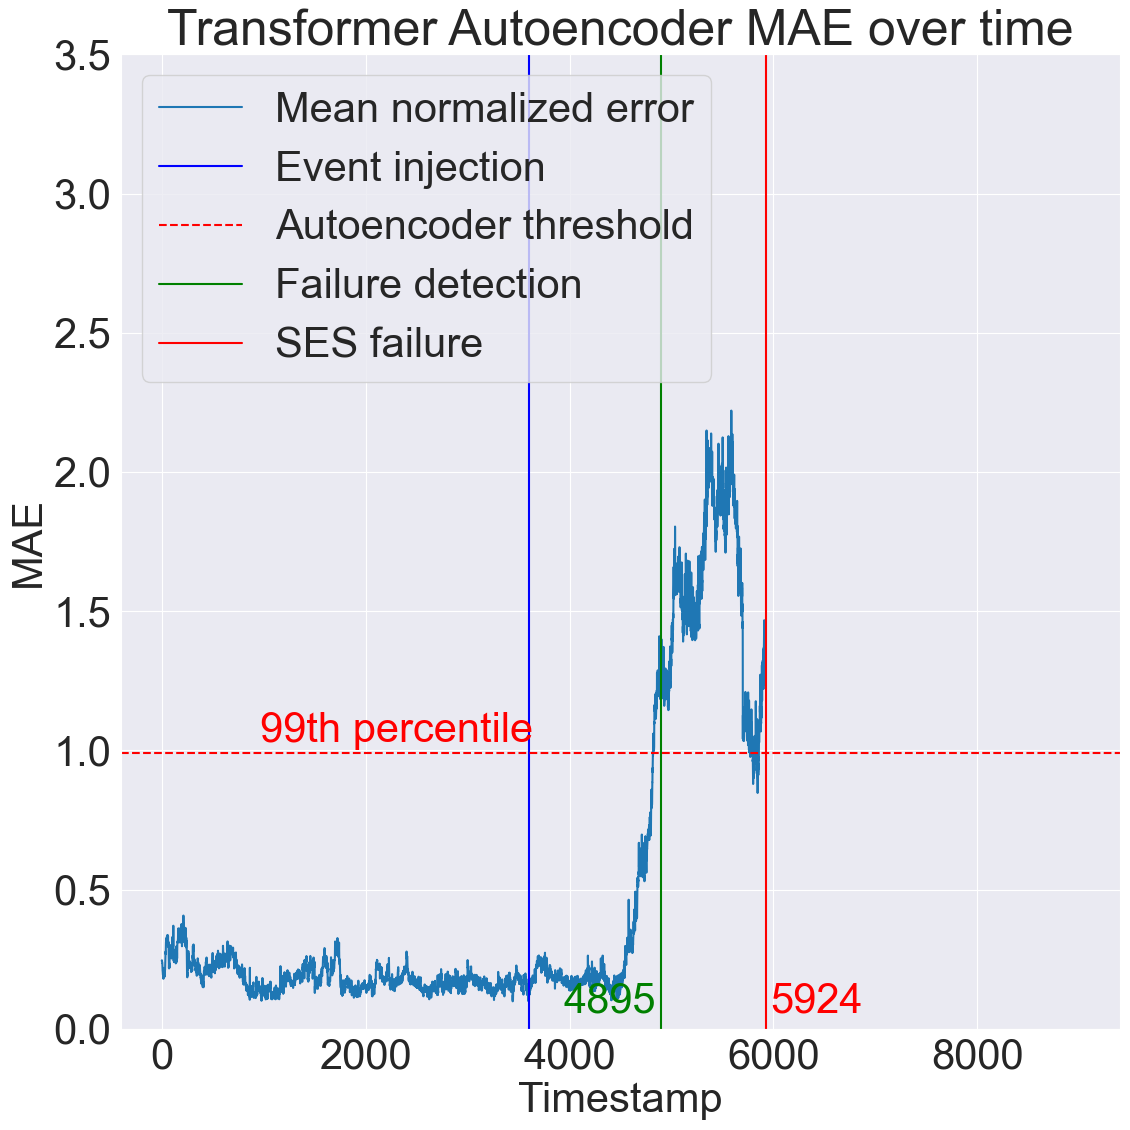


FAILURE DETECTED AT TIMESTAMP 4895, 1295 seconds after injection and 1029 seconds before crash
Results saved to 'results/continual/' folder



In [46]:
# Plot final results

plt.rcParams["figure.figsize"] = (12, 12)
plt.rcParams.update({'font.size': 30})

mean_normalized_errors = pd.DataFrame(index = mae_event_df.index)
normalized_thresholds_99 = []
detect_time = max_count
confidence = 1

for indicator in mae_df.columns:
    errors = mae_df[indicator]
    errors_fail = mae_event_df[indicator]

    # Normalize errors wrt training errors
    normalized_errors = (errors_fail - min(errors)) / (max(errors) - min(errors))
    mean_normalized_errors[indicator] = normalized_errors

mean_normalized_errors['mean_error'] = mean_normalized_errors.mean(axis = 1).reset_index(drop = True)
mean_normalized_errors.to_csv('results/data/continual/' + event + '_' + hour + '_MAE_transformer.csv', index = False)

# Find timestamps where autoencoder error is > 0.99 for more consecutive timestamps
exceeding_timestamp = compute_failure(mean_normalized_errors['mean_error'], 0.99, detect_time, confidence)

plt.figure()
if exceeding_timestamp:
    x_range = np.arange(len(mean_normalized_errors['mean_error']))
    masked_normalized_errors = np.where(x_range <= failure_timestamp, mean_normalized_errors['mean_error'], np.nan)
    plt.plot(x_range, masked_normalized_errors, label = 'Mean normalized error')
else:
    plt.plot(mean_normalized_errors.index, mean_normalized_errors['mean_error'], label = 'Mean normalized error')
plt.axvline(x = 3600, color = 'blue', label = 'Event injection')
plt.axhline(y = 0.99, color = 'red', linestyle = '--', label = 'Autoencoder threshold')
before = -1
after = -1
if exceeding_timestamp:
    plt.axvline(x = exceeding_timestamp, color = 'green', linestyle = '-', label = 'Failure detection')
    plt.text(exceeding_timestamp - 500, 0.03, f'{exceeding_timestamp}', color = 'green', ha = 'center', va = 'bottom')
    if failure_timestamp != 0:
        before = failure_timestamp - exceeding_timestamp
        after = exceeding_timestamp - 3600
if failure_timestamp != 0:
    plt.axvline(x = failure_timestamp, color = 'r', linestyle = '-', label = 'SES failure')
    plt.text(failure_timestamp + 500, 0.03, f'{failure_timestamp}', color = 'r', ha = 'center', va = 'bottom')
plt.title('Transformer Autoencoder MAE over time')
plt.annotate(f'99th percentile', xy = (1500, 1.03), xytext = (2300, 1.03),
             horizontalalignment = 'center', color = 'r')
plt.xlabel('Timestamp')
plt.ylabel('MAE')
plt.ylim(0, 3.5)
plt.xlim(-400, 9400)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc = 'upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('results/graphs/continual/' + event + '_' + hour + '_MAE_transformer.png', dpi = 300)
finish = time.perf_counter()
total_time += finish - start
if run_all == 'no':
    plt.show()
if exceeding_timestamp:
    print(f"\nFAILURE DETECTED AT TIMESTAMP {exceeding_timestamp}, {after} seconds after injection and {before} seconds before crash")
else:
    print(f"\nNO FAILURE DETECTION")
print('Results saved to \'results/continual/\' folder\n')
plt.close()

In [47]:
if run_all == 'no':
    print('PREDICTOR execution time: ' + str(round(finish - start, 3)) + ' seconds')
print('Total execution time: ' + str(round(total_time, 3)) + ' seconds')

PREDICTOR execution time: 1.043 seconds
Total execution time: 48.67 seconds
